# Boston Marathon Challenge

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

## Data Import and Cleaning
The data was obtained from https://github.com/llimllib/bostonmarathon/blob/master/results/2014/results.csv. It is all the Boston marathon finishing times from the 2014 race, and includes both wheelchair racers and runners. 

During the initial data exploration it was noted that several of the numeric values were identified as objects. These numeric values (race split time) will be converted to floats. Additionally, there were several columns with missing values. The ctz column is missing over 90% of the data. This column will be dropped. The distances split columns, the overall column, and pace columns will be dropped from the clustering group as these are highly correlated to the overall pace.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
import pandas_profiling

%matplotlib inline

In [34]:
# Import data
df = pd.read_csv('results.csv')
pd.read_csv('results.csv').profile_report()

In [35]:
# Check Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [36]:
df.isna().sum()

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64

In [37]:
# Drop Columns
drop_var = ['5k', '10k', '20k', 'half', '25k', '30k', '40k',
       'ctz', 'state', 'overall', 'pace', '35k']

df = df.drop(df[drop_var], axis=1)

# Drop missing rows
df = df.dropna()

df.isna().sum()

name         0
division     0
gender       0
age          0
official     0
bib          0
genderdiv    0
country      0
city         0
dtype: int64

## Data Exploration
The number of runners from different countries are 78. The country and gender column values will be assigned integers based on their categorical group. For example females will be assigned 1, and males will be assigned 0. The data will be split between the male and female groups to see if there are any differences between the two genders. Additionally, the data will be normalized before clustering. The two values that will be explored in the clustering will be the age of the runners and the countries of the runners with their offical finishing time. 

In [38]:
df.head()

,name,division,gender,age,official,bib,genderdiv,country,city
0,"Yamamoto, Hiroyuki",8,M,47,85.25,W1,8,JPN,Fukuoka
1,"Jeptoo, Rita",1,F,33,138.95,F1,1,KEN,Eldoret
2,"Van Dyk, Ernst F.",1,M,41,80.60,W2,1,RSA,Paarl
3,"Dibaba, Mare",3,F,24,140.58,F2,3,ETH,Shoa
4,"Hokinoue, Kota",2,M,40,81.23,W3,2,JPN,Nogata Fukuoka


In [43]:
# Check the unique number of values for country
num_country = len(np.unique(df['country']))

print('Number of Countries: {}'.format(num_country))

# Print countries with highest number of participants
print('\nCountries with the highest number of participants:')
df['country'].value_counts().head()

Number of Countries: 78

Countries with the highest number of participants:


USA    27233
CAN     2175
GBR      346
ITA      212
MEX      205
Name: country, dtype: int64

In [9]:
objects = ['country', 'gender']

for obj in objects:
    temp = {i: j for j, i in enumerate(set(df[obj]))} 
    res = [temp[i] for i in df[obj]] 
    df[obj] = list(res)

# X is the features
X = df.select_dtypes(exclude='object')
X_female = X[X['gender']==1]
X_male = X[X['gender']==0]

print(X_male.head())
print(X_female.head())

X_female = normalize(X_female)
X_male = normalize(X_male)

   division  gender  age  official  genderdiv  country
0         8       0   47     85.25          8       32
2         1       0   41     80.60          1       66
4         2       0   40     81.23          2       32
6         4       0   28     84.65          4       57
7         5       0   29    129.83          5       69
    division  gender  age  official  genderdiv  country
1          1       1   33    138.95          1        0
3          3       1   24    140.58          3       69
5          4       1   29    140.68          4        0
10         8       1   30    143.00          8        0
13        17       1   33    152.07         17        0


## KMeans
The elbow charts below show that the ideal number of clusters for males is 4 and for females it is 4. The KMeans clusters will be compared will the Mean Shift clusters in the Summary and Conclusion section below. 

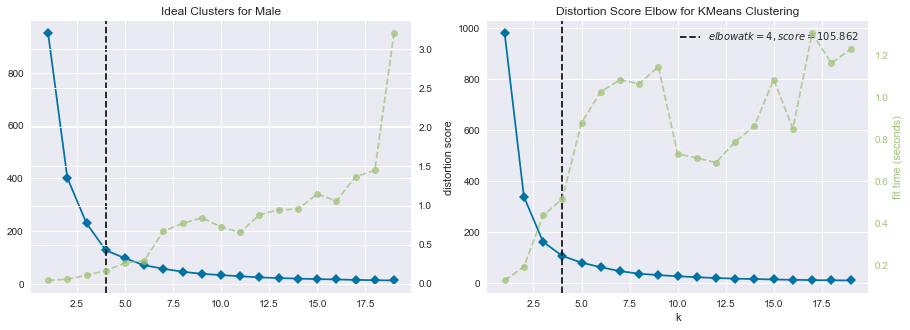

In [30]:
model = KMeans()

plt.figure(figsize=(15, 5))

# Find the optimal number of clusters for KMeans
plt.subplot(1 , 2, 1)
vis = KElbowVisualizer(model, k=(1,20))
vis.fit(X_male)
#vis.poof()
n_male = vis.elbow_value_
plt.title('Ideal Clusters for Male')

plt.subplot(1 , 2, 2)
vis = KElbowVisualizer(model, k=(1,20))
vis.fit(X_female)
vis.poof()
n_female = vis.elbow_value_

plt.show()

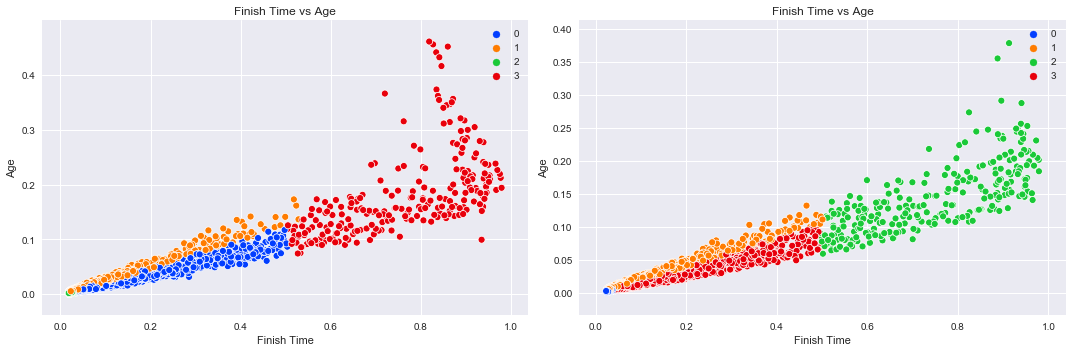

In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
model = KMeans(n_clusters=n_male).fit_predict(X_male)
pal = sns.color_palette('bright', n_male)
sns.scatterplot(x=X_male[:,3], y=X_male[:,2], hue=model, palette=pal)
plt.xlabel('Finish Time')
plt.ylabel('Age')
plt.title('Finish Time vs Age')

plt.subplot(1, 2, 2)
model = KMeans(n_clusters=n_female).fit_predict(X_female)
pal = sns.color_palette('bright', n_female)
sns.scatterplot(x=X_female[:,3], y=X_female[:,2], hue=model, palette=pal)
plt.xlabel('Finish Time')
plt.ylabel('Age')
plt.title('Finish Time vs Age')

plt.tight_layout()
plt.show()

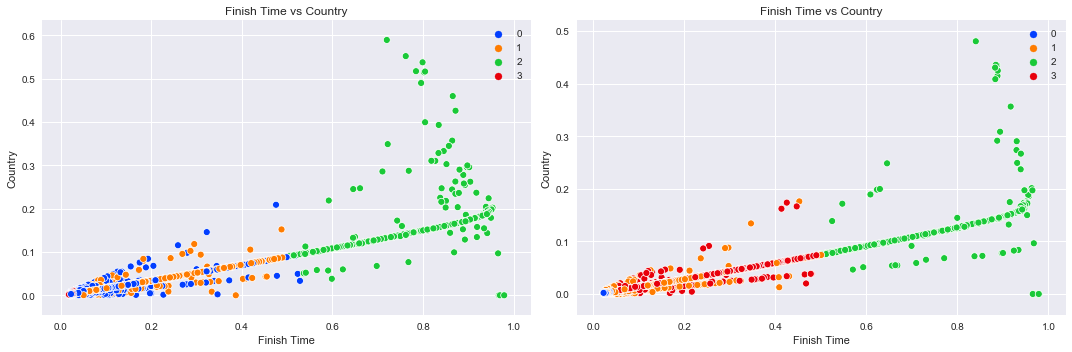

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
model = KMeans(n_clusters=n_male).fit_predict(X_male)
pal = sns.color_palette('bright', n_male)
sns.scatterplot(x=X_male[:,3], y=X_male[:,5], hue=model, palette=pal)
plt.xlabel('Finish Time')
plt.ylabel('Country')
plt.title('Finish Time vs Country')

plt.subplot(1, 2, 2)
model = KMeans(n_clusters=n_female).fit_predict(X_female)
pal = sns.color_palette('bright', n_female)
sns.scatterplot(x=X_female[:,3], y=X_female[:,5], hue=model, palette=pal)
plt.xlabel('Finish Time')
plt.ylabel('Country')
plt.title('Finish Time vs Country')

plt.tight_layout()
plt.show()

## Mean Shift
The same number of clusters above will be used for the Mean Shift below. The results will be compared in the 'Summary and Conclusion' section below.

In [48]:
# Set the bandwidth 
band = estimate_bandwidth(X_male, quantile=.47, n_samples=5000)

# Fit model
model = MeanShift(bandwidth=band, bin_seeding=True)
model.fit(X_male)

# Extract cluster assignments for each data point
labels_male = model.labels_

# Coordinates of the cluster centers
centers = model.cluster_centers_

# Count our clusters.
male_clusters = len(np.unique(labels_male))

print("Number of estimated clusters for males: {}".format(male_clusters))

Number of estimated clusters for males: 4


In [45]:
# Set the bandwidth 
band = estimate_bandwidth(X_female, quantile=.47, n_samples=5000)

# Fit model
model = MeanShift(bandwidth=band, bin_seeding=True)
model.fit(X_female)

# Extract cluster assignments for each data point
labels_female = model.labels_

# Coordinates of the cluster centers
centers = model.cluster_centers_

# Count our clusters.
female_clusters = len(np.unique(labels_female))

print("Number of estimated clusters for females: {}".format(female_clusters))

Number of estimated clusters for females: 4


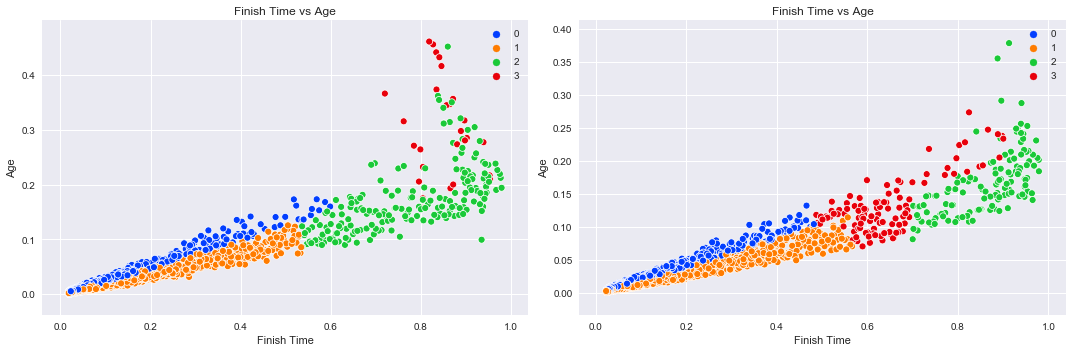

In [49]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
pal = sns.color_palette('bright', male_clusters)
sns.scatterplot(x=X_male[:,3], y=X_male[:,2], hue=labels_male, palette=pal)
plt.xlabel('Finish Time')
plt.ylabel('Age')
plt.title('Finish Time vs Age')

plt.subplot(1, 2, 2)
pal = sns.color_palette('bright', female_clusters)
sns.scatterplot(x=X_female[:,3], y=X_female[:,2], hue=labels_female, palette=pal)
plt.xlabel('Finish Time')
plt.ylabel('Age')
plt.title('Finish Time vs Age')

plt.tight_layout()
plt.show()

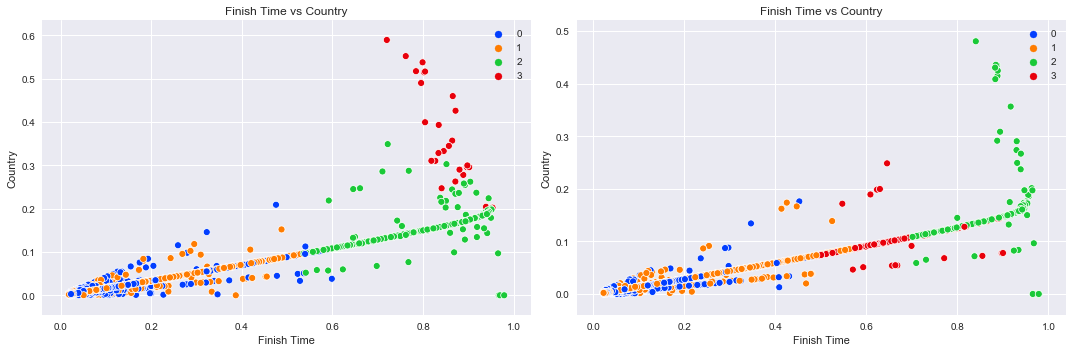

In [50]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
pal = sns.color_palette('bright', male_clusters)
sns.scatterplot(x=X_male[:,3], y=X_male[:,5], hue=labels_male, palette=pal)
plt.xlabel('Finish Time')
plt.ylabel('Country')
plt.title('Finish Time vs Country')

plt.subplot(1, 2, 2)
pal = sns.color_palette('bright', female_clusters)
sns.scatterplot(x=X_female[:,3], y=X_female[:,5], hue=labels_female, palette=pal)
plt.xlabel('Finish Time')
plt.ylabel('Country')
plt.title('Finish Time vs Country')

plt.tight_layout()
plt.show()

# Summary and Conclusion
It was acually surprising how similar the clusters were between the KMeans and the Means Shift. For the 'Finish Time vs Age' groups, the better method was the Means Shift. The charts for both males and females show the that two of the age groups are stacked. This is not surprising considering the marathon qualifying times. The Boston Marathon requires runners from ages 18-34 to run a marathon under 3h 5min in 2014; for the 35-45 age group, runners need to run a marathon under 3h 15min. This means that a large group of the population in the data will be finishing around the same time even though there is a huge age gap. Another reason that the Mean shift was chosen is because the KMeans clusters did not reflect this aspect of the Marathon. For both males and females the KMeans clustered a tiny group in the very tip of the chart. This means that the very youngest of runners were the fastest, which when one looks at the data this is not accurate. 

'Finish Time vs Country' had some very interesting clusters. The country with the largest number of participants was the US with 27k runners. Historically, US runners are not the top finishers in the Boston Marathon. While US runners have won several times in the past, African runners typically win high profile marathons. The best method that reflects this is the 'Finish Time vs Country' It clearly shows that there is a small group at the very tip of both charts and the rest of the chart has various other groupings. 

Overall, the clustering methods did a great job at creating ideal groups for the boston marathon. 